# Overfitting and underfitting
In this tutorial I will familiarize myself with how to deal with underfitting or overfitting using Keras. Of course I am familiar with the concepts, which is why I will skip the long verbose intro of the tutorial. Let's dive right in.

In [2]:
import tensorflow as tf 

from tensorflow.keras import layers
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt
import numpy as np
import pathlib
import shutil
import tempfile 

# Additional libraries I will use
from random import seed
from random import randint
from random import sample
seed(1)

In [17]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [18]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

## Higgs dataset!
Yeah, some particle physics here. I'm excited. This dataset contains 11 million examples, with 28 features and a binary class.

In [19]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

After downloading the dataset, we repack it so that it produces automatically features and labels. In addition, instead of repacking each row individually, we make a new dataset taking batches of 10000 examples, it packs it to produce features and labels, and then splits the batches back up.

In [20]:
FEATURES = 28
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:],1)
    return features, label

In [21]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

Let's do some data inspection, shall we? (I have no idea what the steps before did.)

Are the features normal?

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


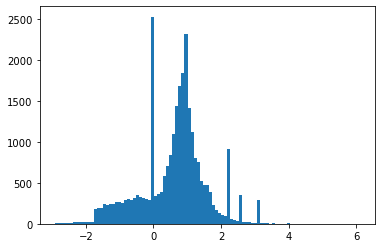

In [22]:
for features, label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins=101)

While the data aren't perfectly normal, this should be sufficient for the tutorial. (Why must the data be normal? The tutorial doesn't really explain what we are going to do...)

To avoid complications, let us take only the first 1000 samples for validation, and 10000 after for training, using the functions Dataset.skip and Dataset.take. The method cache() ensures that the loader does not need to re-read data from the file on each epoch.

In [23]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

Because these datasets return individual examples, we use the .batch method to create batches of appropriate size for training. Before batching, we need to .shuffle and .repeat on the training set (but... whzy? \*confused Ryan Raynolds face\*)

In [24]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

## Demonstrate overfitting

The best way to avoid overfitting is to start with a small model. The number of learnable parameters in a model is called "capacity". The challenge for deep learning methods is the generalization step, while they are generally very good at fitting training data.

Obviously there is no magical formula determining the perfect capacity of the model. Thus, it's better to start with few layers and parameters, and build up from there. As a baseline, we start with a simple model using only densely-connected layers, then build larger models, and compare them.

### Training procedure
There is the possibility to gradualy reduce the learning rate during training. This generally leads to better training models. We use the method optimizers.schedules. We create a hyperbolic decrease of the learning rate to 1/2 of the base rate at 1000 epochs, 1/3 at 2000 epochs, and so on.

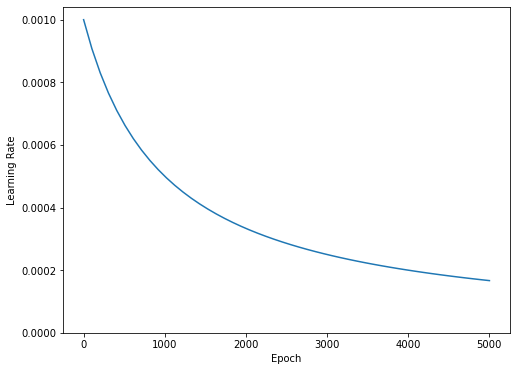

In [25]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False
)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

step = np.linspace(0, 100000)
lr = lr_schedule(step)
plt.figure(figsize=(8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

Since each model in the tutorial will use the same training configuration, we set these up in a reusable way.

In [29]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
        tf.keras.callbacks.TensorBoard(logdir/name)
    ]

In [30]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[
                      tf.keras.losses.BinaryCrossentropy(from_logits=True, name='binary_crossentropy'),
                      'accuracy'])

    model.summary()

    history = model.fit(
        train_ds,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_data=validate_ds,
        callbacks=get_callbacks(name),
        verbose=0)
    return history

Let's start from training a model.

In [28]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

size_histories = {}

size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                464       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


(0.5, 0.7)

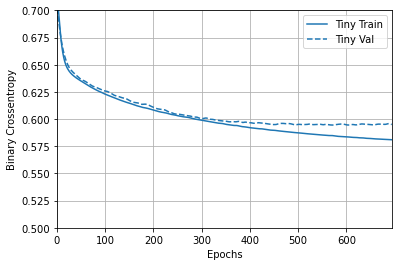

In [31]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

Let's do a slightly larger model.

In [32]:
small_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16)                464       
                                                                 
 dense_5 (Dense)             (None, 16)                272       
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4952,  binary_crossentropy:0.7188,  loss:0.7188,  val_accuracy:0.4740,  val_binary_crossentropy:0.7115,  val_loss:0.7115,  
....................................................................................................
Epoch: 100, accuracy:0.6237,  binary_crossentropy:0.6116,  loss:0.6116,  

Medium model anyone?

In [33]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

size_histories['Medium'] = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 64)                1856      
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4989,  binary_crossentropy:0.7007,  loss:0.7007,  val_accuracy:0.4870,  val_binary_crossentropy:0.6820,  val_loss:0.6820,  
....................................

...aaaaaaaaaaaaaand of course time for a huge model.

In [34]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

size_histories['large'] = compile_and_fit(large_model, "sizes/Large")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 512)               14848     
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dense_13 (Dense)            (None, 512)               262656    
                                                                 
 dense_14 (Dense)            (None, 512)               262656    
                                                                 
 dense_15 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5099,  binary_crossentropy

## Plot training and validation losses

Solid lines: training loss; dashed lines: validation loss (i.e. lower validation loss = better model).
If validation loss begins to stagnate while the training metric keeps improving, we are probably close to overfitting. If the validation metric goes in the wrong direction, the model is very obviously overfitting.

Text(0.5, 0, 'Epochs [Log Scale]')

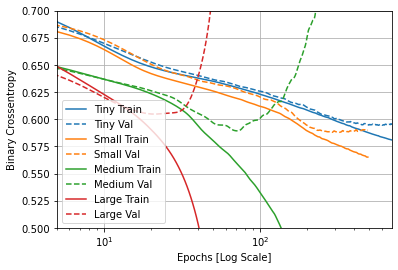

In [35]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

The tiny and small models went OK for a longer time, while medium and large model started to overfit quite early. We copy the training logs from the Tiny model to use as baseline for comparison.

In [36]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

WindowsPath('C:/Users/xtomma/AppData/Local/Temp/tmpk32al9_d/tensorboard_logs/regularizers/Tiny')

## Strategies to avoid overfitting

Regularization is a first step. There will always be multiple models that can explain the data, and we aim at choosing the simpler models. A common way to mitigate overfitting is to put constraints on the complexity of a network, by forcing its weights to only take small values. This is done by adding to the loss function of a network a cost for having large weights.
- L1 regularization: cost added is proportional to the absolute value of the weights coefficients (e.g. LASSO)
- L2 regularization: cost added is proportional to the square of the value of the weights coefficients. (e.g. Ridge)
L1 regularization pushes weights towards zero, while L2 pushes them to be very small. L2 is more common as L1 encourages a sparse model. 

In the next step, the value 0.001 in regularizers.l2 means that each coefficient in the weight matrix will add 0.001*weight_coefficient**2 to the loss.

In [37]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)                 
])

regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']
regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 512)               14848     
                                                                 
 dense_17 (Dense)            (None, 512)               262656    
                                                                 
 dense_18 (Dense)            (None, 512)               262656    
                                                                 
 dense_19 (Dense)            (None, 512)               262656    
                                                                 
 dense_20 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5158,  binary_crossentropy

(0.5, 0.7)

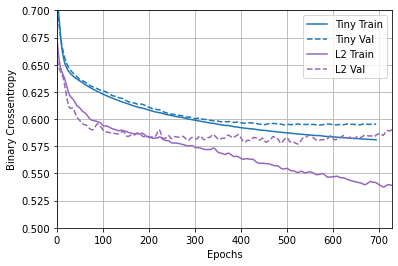

In [38]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

This is definitely much better than the large model that we defined above. It is surprisingly resisting overfitting. Let's see another strategy to decrease overfitting: adding dropouts.

A dropout is very effective and it has become very used. In each layer, each node needs to produce independent outputs that cannot rely on the others. Thus, the idea of the dropout is to drop randomly (set to zero) some outputs of a layer that will then not be input for the next layer. The dropout rate is the fraction of features that are being zeroed-out. 

In [39]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation="elu", input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 512)               14848     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_23 (Dense)            (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_24 (Dense)            (None, 512)              

(0.5, 0.7)

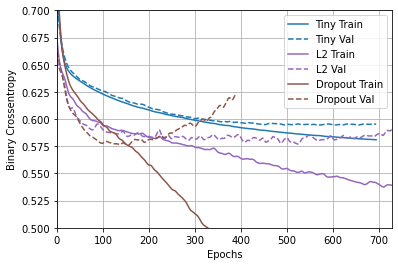

In [40]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

Even here, it is not great. 

Finally, in the tutorial they show that the best option here is to combine both L2-regularization and dropout technique. It is quite easy to construct from all I did so far, so I will skip it to move to a better tutorial (yeah, this one sucked hard).